In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

2023-11-03 18:09:26,160 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 ontology = imas/3, version = 0.2.1 ( extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty ) 

 Run by salmon on Surface at 2023-11-03T18:09:26.160243

#######################################################################################################################



In [2]:
WORKSPACE = "/home/salmon/workspace"

# f"{WORKSPACE}/gacode/neo/tools/input/profile_data"
input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")
output_path = f"{WORKSPACE}/output"

tokamak = Tokamak(f"file+iterprofiles://{next(input_path.glob('*.xls')).as_posix()}",
                  f"file+geqdsk://{next(input_path.glob('**/*.txt')).as_posix()}",
                  device="iter",
                  transport_solver={"code":  {"name": "fytrans", }})


tokamak.transport_solver.refresh(
    equilibrium=tokamak.equilibrium,
    core_profiles=tokamak.core_profiles,
    core_transport=tokamak.core_transport,
    core_sources=tokamak.core_sources,
)

2023-11-03 18:09:26,244 [   fytok]     INFO: Load module spdm.plugins.data.plugin_xml
2023-11-03 18:09:26,423 [   fytok]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-03 18:09:26,486 [   fytok]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2023-11-03 18:09:26,515 [   fytok]     INFO: Load module fytok.plugins.transport_solver_numerics.fytrans
2023-11-03 18:09:26,849 [   fytok]     INFO: Load module fytok.plugins.equilibrium.eq_analyze
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
Singular Jacobian encountered when solving the collocation system on iteration 1. 
Maximum relative residual: 1.95e+03 
Maximum boundary residual: 3.88e+22


RuntimeError: A singular Jacobian encountered when solving the collocation system.

2023-11-03 18:09:30,452 [   fytok]     INFO: Load module spdm.view.view_matplotlib


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


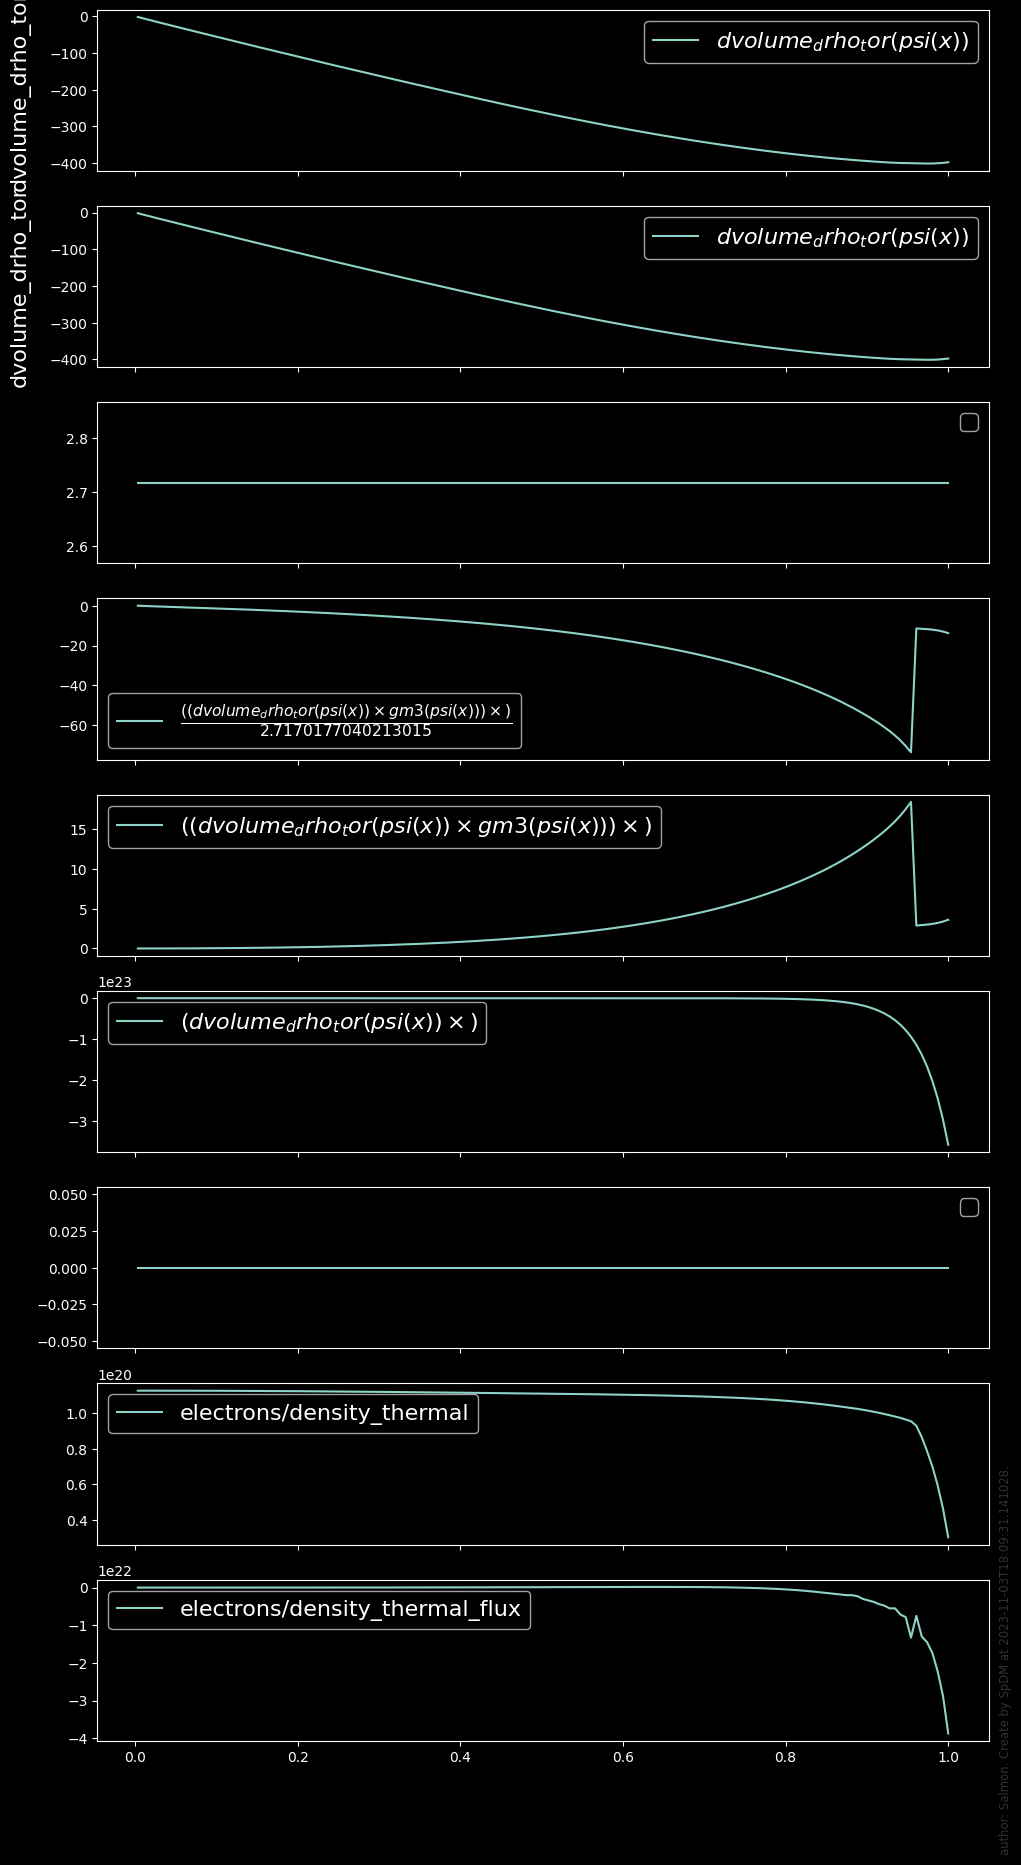

In [3]:
equ = tokamak.transport_solver.time_slice.current.solver_1d.equation[0]
fig = sp_view.plot([
    * equ.coefficient,
    (equ.primary_quantity.profile, {"label": equ.primary_quantity.identifier}),
    (equ.primary_quantity.flux, {"label": f"{equ.primary_quantity.identifier}_flux"}),
],
    x_axis=tokamak.transport_solver.time_slice.current.solver_1d.grid.rho_tor_norm)

In [ ]:
core_source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d

In [ ]:
core_source_1d.electrons.particles